# BBM 409 - Programming Assignment 1

#### Erdinç Arıcı 2210356035

## Understanding Perceptron Learning Algorithm

### 1. Data Loading and Exploration

In this assignment, the goal is to apply and explore the Perceptron Learning Algorithm and Fisher’s Linear Discriminant (FDA) on the Banknote Authentication Dataset. By coding the Perceptron and FDA from scratch, the objective is to classify banknotes as either authentic (class 1) or fake (class 0). This assignment consists of several stages, including the implementation of the algorithms, evaluation of their performance, and visualization of their decision boundaries. This process will help in gaining a deeper understanding of the principles, limitations, and effectiveness of the Perceptron and FDA in a practical binary classification problem.

For this analysis, the Banknote Authentication Dataset from the UCI repository is used. This dataset contains 1,372 samples extracted from banknote images, with each sample including four features: Variance, Skewness, Kurtosis, Entropy. The target variable has two values: 1 for authentic banknotes, 0 for fake banknotes. The dataset will be divided into training and test sets to evaluate the performance of both algorithms.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
banknote_authentication = fetch_ucirepo(id=267) 

X = banknote_authentication.data.features 
y = banknote_authentication.data.targets 

print(banknote_authentication.metadata) 
print(banknote_authentication.variables) 

{'uci_id': 267, 'name': 'Banknote Authentication', 'repository_url': 'https://archive.ics.uci.edu/dataset/267/banknote+authentication', 'data_url': 'https://archive.ics.uci.edu/static/public/267/data.csv', 'abstract': 'Data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1372, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Fri Feb 16 2024', 'dataset_doi': '10.24432/C55P57', 'creators': ['Volker Lohweg'], 'intro_paper': None, 'additional_info': {'summary': 'Data were extracted from images that were taken from genuine and forged banknote-like specimens.  For digitization, an industrial camera usually used for print inspection was used. The final im

In [3]:
print(f"Dataset size: {X.shape[0]} rows, {X.shape[1] + 1} columns (last column for target values)")
print("\nSummary statistics for the features:\n", X.describe())
print("\nTarget variable distribution:\n", y.value_counts().to_string())

Dataset size: 1372 rows, 5 columns (last column for target values)

Summary statistics for the features:
           variance     skewness     curtosis      entropy
count  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657
std       2.842763     5.869047     4.310030     2.101013
min      -7.042100   -13.773100    -5.286100    -8.548200
25%      -1.773000    -1.708200    -1.574975    -2.413450
50%       0.496180     2.319650     0.616630    -0.586650
75%       2.821475     6.814625     3.179250     0.394810
max       6.824800    12.951600    17.927400     2.449500

Target variable distribution:
 class
0        762
1        610


In [4]:
print("Missing values check: \n", X.isnull().sum().to_string())

Missing values check: 
 variance    0
skewness    0
curtosis    0
entropy     0


There are no missing values in the dataset. This means that we don’t need any additional processing for data cleaning.

In [5]:
x_np, y_np = np.array(X), np.array(y)

### 2. Data Preprocessing

Using a validation set to evaluate your model, rather than relying solely on training data, is crucial for assessing the model’s generalization ability. When we evaluate the model only on the training data, we risk the model memorizing or overfitting the data, which leads to misleadingly high performance. However, when we assess the model on unseen data in the validation set, we can get a clearer picture of how well the model will perform in real-world applications. Evaluating on unseen data helps us understand if the model can generalize beyond the specific examples it was trained on, providing insights into its flexibility and robustness. This way, we can detect overfitting and make necessary adjustments to improve the model’s accuracy on new data.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x_np, y_np, test_size = 0.2, random_state = 47)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", y_train.shape)
print("Shape of Y_test:", y_test.shape)

Shape of X_train: (1097, 4)
Shape of X_test: (275, 4)
Shape of Y_train: (1097, 1)
Shape of Y_test: (275, 1)


In [7]:
scaler = StandardScaler()

x_std_train, y_train[y_train == 0] = scaler.fit_transform(X_train), -1
x_std_test, y_test[y_test == 0] = scaler.transform(X_test), -1

# I chose the first method because standardizing all features to have a mean of 0 and a standard deviation of 1 improves the model’s learning process.
# By applying standardization, the features are scaled to a similar range, which helps the model converge faster and perform better. 

# While writing the perceptron function, using target values directly in the multiplication operation creates a challenge if the target is 0,
# as it leads to a zero effect in calculations. To overcome this, I assigned -1 instead of 0 to the target values. This way,
# the perceptron algorithm can perform the necessary calculations without losing information due to zero values.

### 3. Implementing Perceptron for Binary Classification

The reason for applying the perceptron learning algorithm to this type of data is that our dataset is binary and linearly separable. In the banknote authentication dataset, we aim to determine whether banknotes are real or fake using the features provided. The perceptron algorithm offers an effective and fast solution for such linear classification problems, making it a suitable choice for this dataset.

In [8]:
def predicted_value(w, x, bias):
    return -1 if np.dot(w, x) + bias < 0 else 1

def PLA(x, t, learning_rate = 0.01, epoch = 1000):
    w, bias = np.zeros(x.shape[1]), 0
    for _ in range(epoch):
        for n, x_n in enumerate(x):
            if predicted_value(w, x_n, bias) != t[n]:
                w += learning_rate * t[n] * x_n
                bias += learning_rate * t[n]

    return w, bias

The learning rate and the number of epochs significantly impact the training process of the perceptron algorithm. A very small learning rate causes slow weight updates, which slows down the model’s convergence; on the other hand, a very large learning rate can lead to excessively large weight updates, making the model unstable or preventing it from converging to an optimal solution. Similarly, a low number of epochs may result in the model not learning the data sufficiently (underfitting), while too many epochs can lead to overfitting. Therefore, carefully selecting the learning rate and the number of epochs ensures that the model learns efficiently and stably and generalizes well to new data.

In [9]:
def accuracy(x, t, w, bias):
    correct, predicted_values = 0, []
    for n, x_n in enumerate(x):
        predicted_values.append(predicted_value(w, x_n, bias))
        if predicted_value(w, x_n, bias) == t[n]:
            correct += 1
    accuracy = correct / x.shape[0]
    return accuracy, predicted_values

In [10]:
w, bias = PLA(x_std_train, y_train)

In [11]:
accuracy_train, y_pred_train = accuracy(x_std_train, y_train, w, bias)
print("Training Accuracy:", accuracy_train)

Training Accuracy: 0.9908842297174111


### 4. Evaluating Perceptron for Binary Classification

In [12]:
accuracy_test, _ = accuracy(x_std_test, y_test, w, bias)
print("Testing Accuracy:", accuracy_test)

Testing Accuracy: 0.9818181818181818


Answer the Guiding Questions:
1. What does accuracy tell us about the performance of the model?
2. Why is accuracy sometimes not enough, especially in cases where the data is imbal-
anced? Explain a scenario where a high accuracy might be misleading.

1 - Accuracy is a performance metric that shows the proportion of correct predictions made by the model on the entire dataset. A high accuracy score indicates that the model performs well overall and can classify or predict data correctly.

2 - When there is significant class imbalance in the dataset, accuracy can be misleading. In such cases, the model may achieve high accuracy by predicting the majority class more frequently, while failing to accurately predict the minority class.

Scenario - Consider a fraud detection system. Suppose that 99% of the transactions in the dataset are legitimate, and only 1% are fraudulent. If the model predicts all transactions as legitimate, it will have an accuracy of 99%. Although this high accuracy might suggest good model performance, the model fails to detect any fraudulent transactions. In this case, it does not fulfill its main purpose of identifying fraud. Thus, high accuracy provides a misleading assessment and does not reflect the model’s true performance. For this reason, especially in imbalanced datasets, it is important to consider other performance metrics such as precision, recall, and F1 score.

In [13]:
def calculate_metrics(y_true, y_pred):
    TP, TN, FP, FN = 0, 0, 0, 0
    for true, predicted in zip(y_true, y_pred):
        if true == 1 and predicted == 1:
            TP += 1
        elif true == 1 and predicted == -1:
            FP += 1
        elif true == -1 and predicted == 1:
            FN += 1
        else:
            TN += 1
            
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    return accuracy, precision, recall, f1

y_pred_train = np.array(y_pred_train)
accuracy_train, precision_train, recall_train, f1_train = calculate_metrics(y_train.flatten(), y_pred_train)

print(f"Training Accuracy: {accuracy_train}")
print(f"Training Precision: {precision_train}")
print(f"Training Recall: {recall_train}")
print(f"Training F1 Score: {f1_train}")

Training Accuracy: 0.9908842297174111
Training Precision: 0.9877551020408163
Training Recall: 0.9918032786885246
Training F1 Score: 0.9897750511247443


Answer the Guiding Questions:
1. In what types of problems is precision more important than recall? Give an example
scenario where high precision is desirable but low recall might be acceptable.
2. In what cases is recall more critical? Discuss an example where missing true positives
is more harmful than having false positives.
3. When is the F1 score a better measure than accuracy? Explain why balancing
precision and recall is important in some contexts.
4. What are the limitations of using F1 score alone?

1 - Problems where precision is more important involve situations where the cost of false positives is high. For example, in drug approval testing conducted by a pharmaceutical company, high precision is essential for detecting side effects. If the drug appears to have side effects (false positive), it could be unnecessarily rejected. Therefore, high precision is desired, and missing some side effects (false negatives) may be acceptable since these can be identified through additional testing later.

2 - Sensitivity (recall) is crucial in cases where missing true positives has serious consequences. For example, in cancer screening tests, identifying a sick individual as healthy (false negative) can delay treatment and lead to disease progression. In this case, high sensitivity is essential; identifying healthy individuals as sick (false positives) can be corrected with further testing and is less harmful.

3 - The F1 score is a better metric than accuracy, especially when classes are imbalanced or when false positives and false negatives have different costs. This is because the F1 score reflects a balance between precision and recall by taking their harmonic mean. For example, in medical diagnostics, it is important to both correctly identify patients (high recall) and avoid misdiagnosing healthy individuals (high precision). Balancing precision and recall is critical for patient safety and efficient resource use.

4 - The F1 score provides the average of precision and recall but does not show their individual values, making it harder to understand which metric is higher or lower. Additionally, the F1 score does not account for class imbalance or the varying costs of different error types. Therefore, it is more effective to evaluate the F1 score alongside other metrics rather than relying on it alone.

### 5. Visualization of the Hyperplane

#### Step 1: Feature Selection Using Correlation Analysis

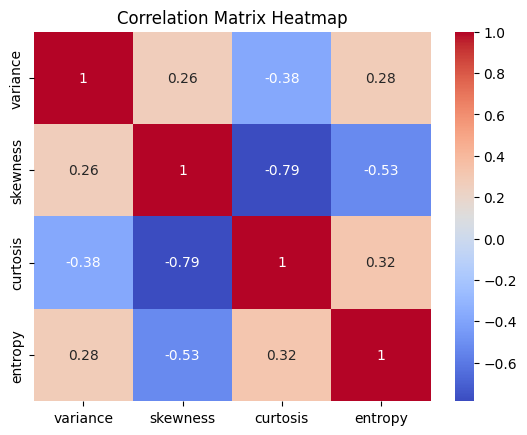

In [14]:
correlation_matrix = X[['variance', 'skewness', 'curtosis', 'entropy']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [15]:
x_slc_train = x_std_train[:,[0,1]] # variance and skewness

#### Step 2: Train the Perceptron on Selected Features

In [16]:
w, bias = PLA(x_slc_train, y_train)

accuracy_train = accuracy(x_slc_train, y_train, w, bias)[0]
print("Training Accuracy:", accuracy_train)

Training Accuracy: 0.8650865998176845


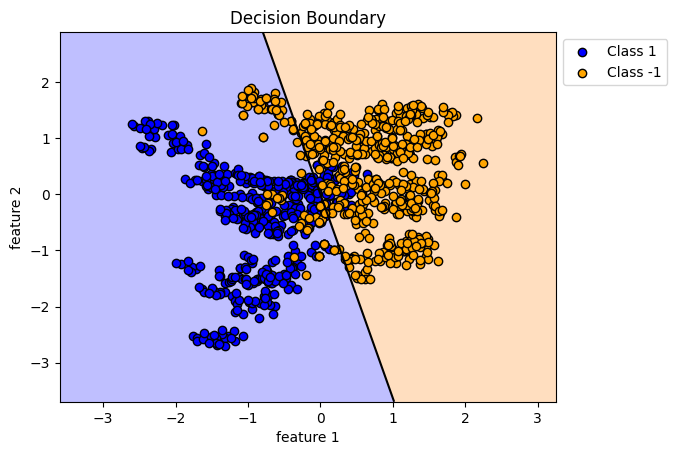

In [17]:
def plot_decision_boundary(X, y, model):
    w, bias = model
    T = y.flatten()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max), np.linspace(y_min, y_max))
    
    line = np.dot(np.c_[x_grid.ravel(), y_grid.ravel()], w) + bias
    line = line.reshape(x_grid.shape)
    plt.contourf(x_grid, y_grid, line, levels=[-np.inf, 0, np.inf], colors=['#FF7F00', '#0000FF'], alpha=0.25)
    plt.contour(x_grid, y_grid, line, levels=[0], colors='black')

    plt.scatter(X[T == 1][:, 0], X[T == 1][:, 1], color='blue', edgecolor='black', label='Class 1')
    plt.scatter(X[T == -1][:, 0], X[T == -1][:, 1], color='orange', edgecolor='black', label='Class -1')

    plt.ylim(y_min, y_max)
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title('Decision Boundary')
    plt.show()

plot_decision_boundary(x_slc_train, y_train, (w, bias))

#### Step 3: Experiment with Different Features
Answer the guiding
questions:
1. How does the decision boundary change when you use different pairs of features?
2. Can you find a pair of features that leads to better separation between the two
classes?

1 - When I train the perceptron model with different pairs of features, the decision boundary changes each time because each feature pair represents the data from a different perspective. This affects the shape and position of the boundary that the model needs to learn to separate the classes; some feature pairs provide a clearer separation between classes, while others present a more ambiguous boundary.

2 - Yes, among the feature pairs I tried, there is one that achieved an accuracy rate of 88%; with the other pairs, I obtained lower accuracies, such as 83%, 81%, 73%, 64% and 50%. These results indicate that the feature pair achieving 88% accuracy provides a better separation between classes, meaning the perceptron can learn a more effective decision boundary with these features.

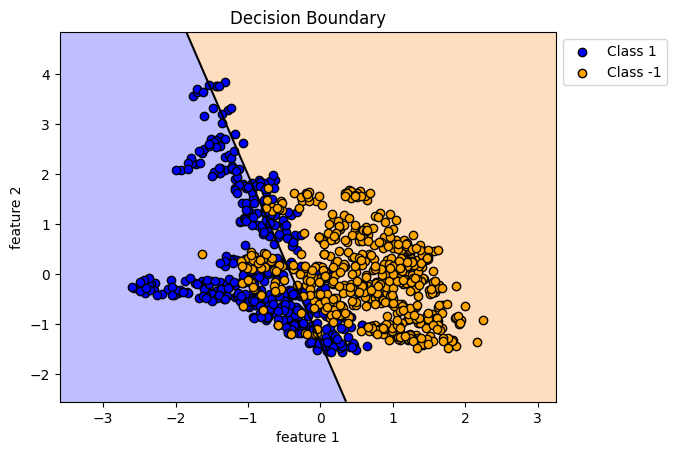

Training accuracy for variance and curtosis:  0.8195077484047402


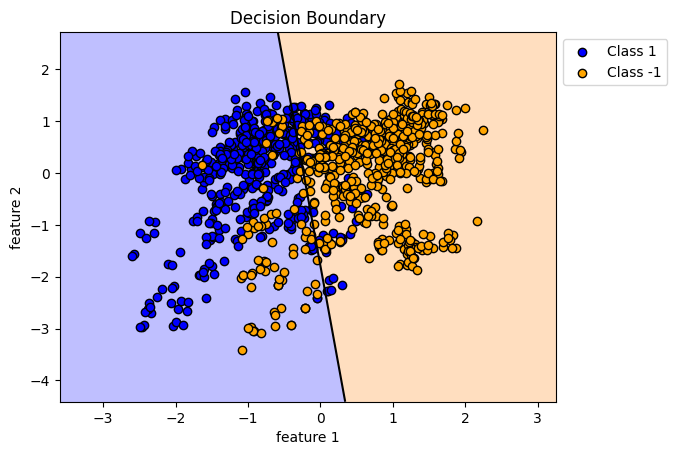

Training accuracy for variance and entropy:  0.8359161349134002


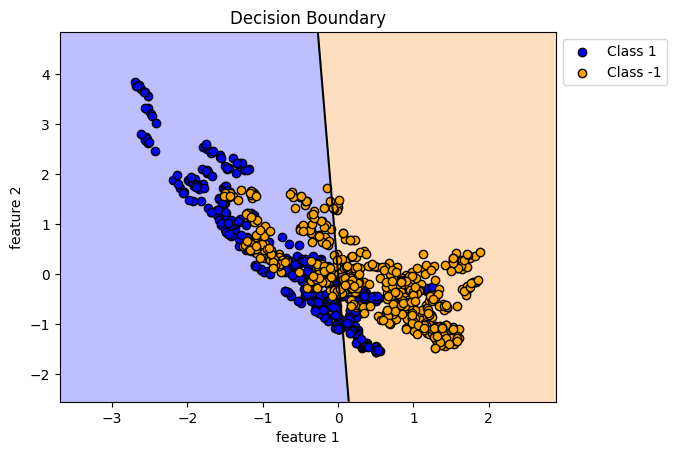

Training accuracy for skewness and curtosis:  0.6444849589790337


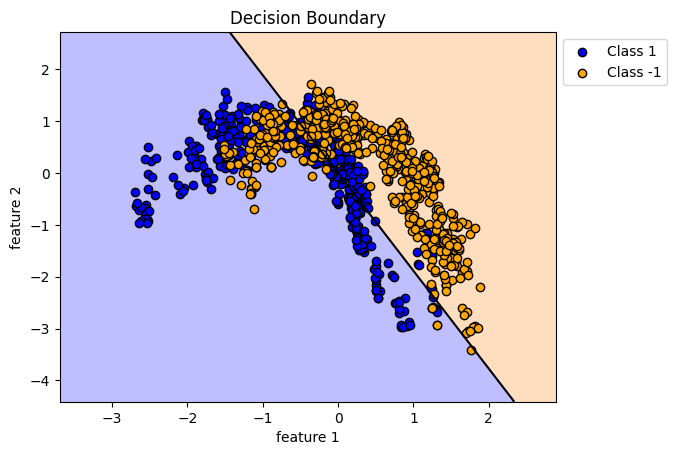

Training accuracy for skewness and entropy:  0.7392889699179581


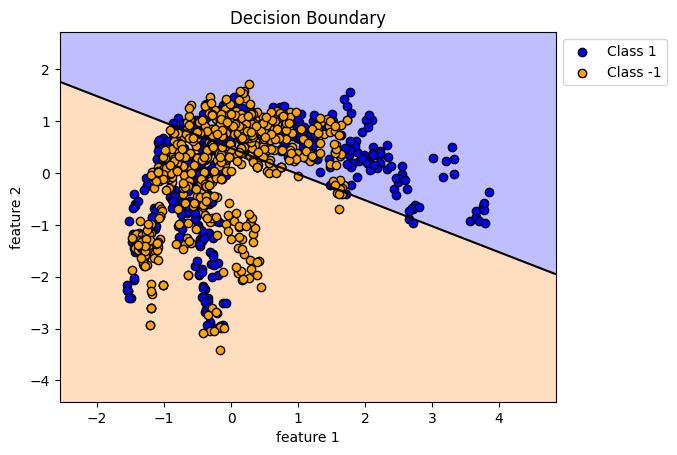

Training accuracy for curtosis and entropy:  0.5068368277119416


In [18]:
feature_pairs = [(0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
feature_names = ['variance', 'skewness', 'curtosis', 'entropy']

for i, j in feature_pairs:
    x_slc = x_std_train[:, [i, j]]
    w, bias = PLA(x_slc, y_train)
    plot_decision_boundary(x_slc, y_train, (w, bias))
    
    accuracy_train = accuracy(x_slc, y_train, w, bias)[0]
    print(f"Training accuracy for {feature_names[i]} and {feature_names[j]}: ", accuracy_train)

1. Visualizing Incremental Learning: Another experiment to help understand the behavior of the Perceptron is to add data incrementally. Start with a small portion of
the dataset and progressively add more data points to train the Perceptron.

2. Observe how the decision boundary shifts: As you add more data, observe how the
hyperplane shifts and adapts to new points. This will help you understand how the
Perceptron continuously adjusts the boundary to separate the classes.

#### Step 5: Analyzing the Hyperplane
Anwer the guiding questions:
1. Why does the hyperplane change with different features or data points?
2. How does the decision boundary relate to the linearly separable nature of the data?

1 - When different features are used, the distribution of the data in space and the relationships between classes change. For this reason, the perceptron learns a different hyperplane for each feature combination. The slope and position of the hyperplane vary depending on how well the features represent the separation between classes.

2 - The decision boundary is a linear hyperplane learned by the perceptron to classify the data. If the data is linearly separable, the perceptron algorithm can find an appropriate decision boundary for this data and correctly separate the classes. Linear separability means that the data can be perfectly divided by a plane or line. The decision boundary is the primary element that enables this separation and defines the border between the two classes.

#### Step 6: Fisher’s Linear Discriminant Projection

In [19]:
def fisher_ld_projection(X, y):
    y = y.ravel()
    class_1 = X[y == 1]
    class_2 = X[y == -1]

    mean_1 = np.mean(class_1, axis=0)
    mean_2 = np.mean(class_2, axis=0)
    
    S_w = np.cov(class_1, rowvar=False) + np.cov(class_2, rowvar=False)
    
    direction = np.linalg.inv(S_w).dot(mean_1 - mean_2)
    direction /= np.linalg.norm(direction)
    return direction

def project_data(X, direction):
    return np.dot(X, direction)

In [20]:
direction = fisher_ld_projection(x_slc_train, y_train)
projected_data = project_data(x_slc_train, direction)

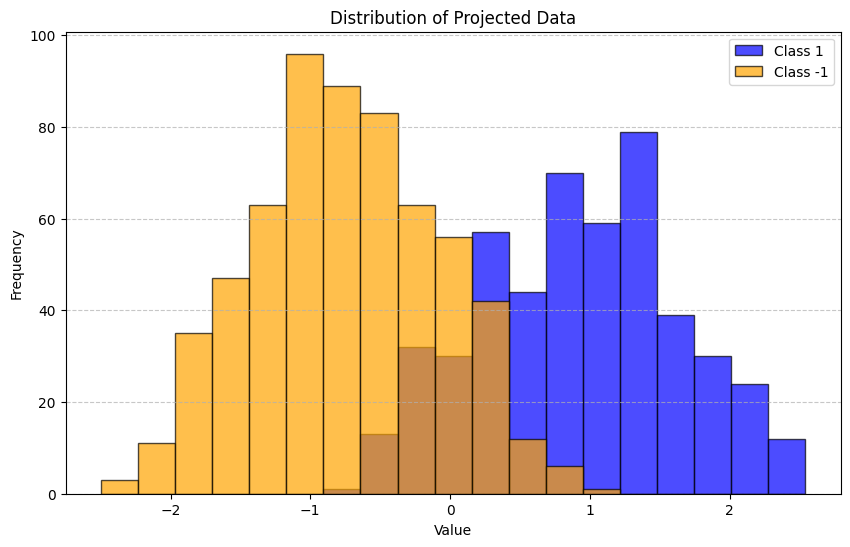

In [21]:
bins = np.linspace(min(projected_data), max(projected_data), 20)
t = y_train.flatten();

plt.figure(figsize = (10, 6))
plt.hist(projected_data[t == 1], bins=bins, alpha=0.7, color='blue', label='Class 1', edgecolor='black')
plt.hist(projected_data[t == -1], bins=bins, alpha=0.7, color='orange', label='Class -1', edgecolor='black')

plt.title("Distribution of Projected Data")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.legend(loc='upper right')
plt.grid(axis='y', linestyle = '--', alpha = 0.7)

plt.show()

Answer the guiding questions:
1. How well does Fisher’s LD separate the two classes in the 1D projected space?
2. Compare the separation of the two classes in the original 2D space (used in the
Perceptron) versus the 1D Fisher’s LD projection. What do you observe about the
class distributions in these spaces?

1 - Fisher's LD method optimizes features to achieve maximum separation by projecting two classes onto a 1-dimensional axis. As seen in the graph, Fisher's LD separates the two classes quite well; the blue and orange values are distinctly separated, with only a few overlapping points. This indicates good separation on the projection axis.

2 - In the original 2D space, the classes are closer together, and some overlaps along the class boundary are observed, which suggests that the perceptron algorithm may struggle to separate the classes. However, in the 1D projection using Fisher's LD, the classes are more distinctly separated. This demonstrates that Fisher’s LD method is effective in enhancing class separation, making the classes more clearly observable in the 1D projection.